In [1]:
import matplotlib.pyplot as plt
import numpy as np

from intermodulation.utils import get_nearest_f

%matplotlib inline


def flip_state(t, target_t, keymask, framerate):
    close_enough = np.isclose(t, target_t, rtol=0.0, atol=1 / (2 * framerate) - 1e-6)
    past_t = t > target_t
    goodclose = (close_enough & keymask) | (past_t & keymask)
    # breakpoint()
    if np.any(goodclose):
        ts_idx = np.argwhere(goodclose).flatten()[-1]
        keymask[ts_idx] = False
        return True, keymask
    return False, keymask

In [12]:
f_vals = np.arange(4, 61, 0.1)

actual_frs_nonoise = []
actual_frs_nonoise_std = []
allflips = []
alltargets = []

framerate = 240
dur = 3.0
t_vals = np.arange(0, dur, (1 / framerate))
for f in f_vals:
    flips = []
    target_ts = np.arange(0, 100, 1 / (2 * f))
    alltargets.append(target_ts)
    keymask = np.ones_like(target_ts).astype(bool)
    t_last = 0.0
    for t in t_vals:
        flip, keymask = flip_state(t, target_ts, keymask, framerate)
        if flip:
            flips.append(t)
    allflips.append(np.array(flips))
    actual_frs_nonoise.append(np.mean(1 / np.diff(flips) / 2))
    actual_frs_nonoise_std.append(np.std(1 / np.diff(flips) / 2))

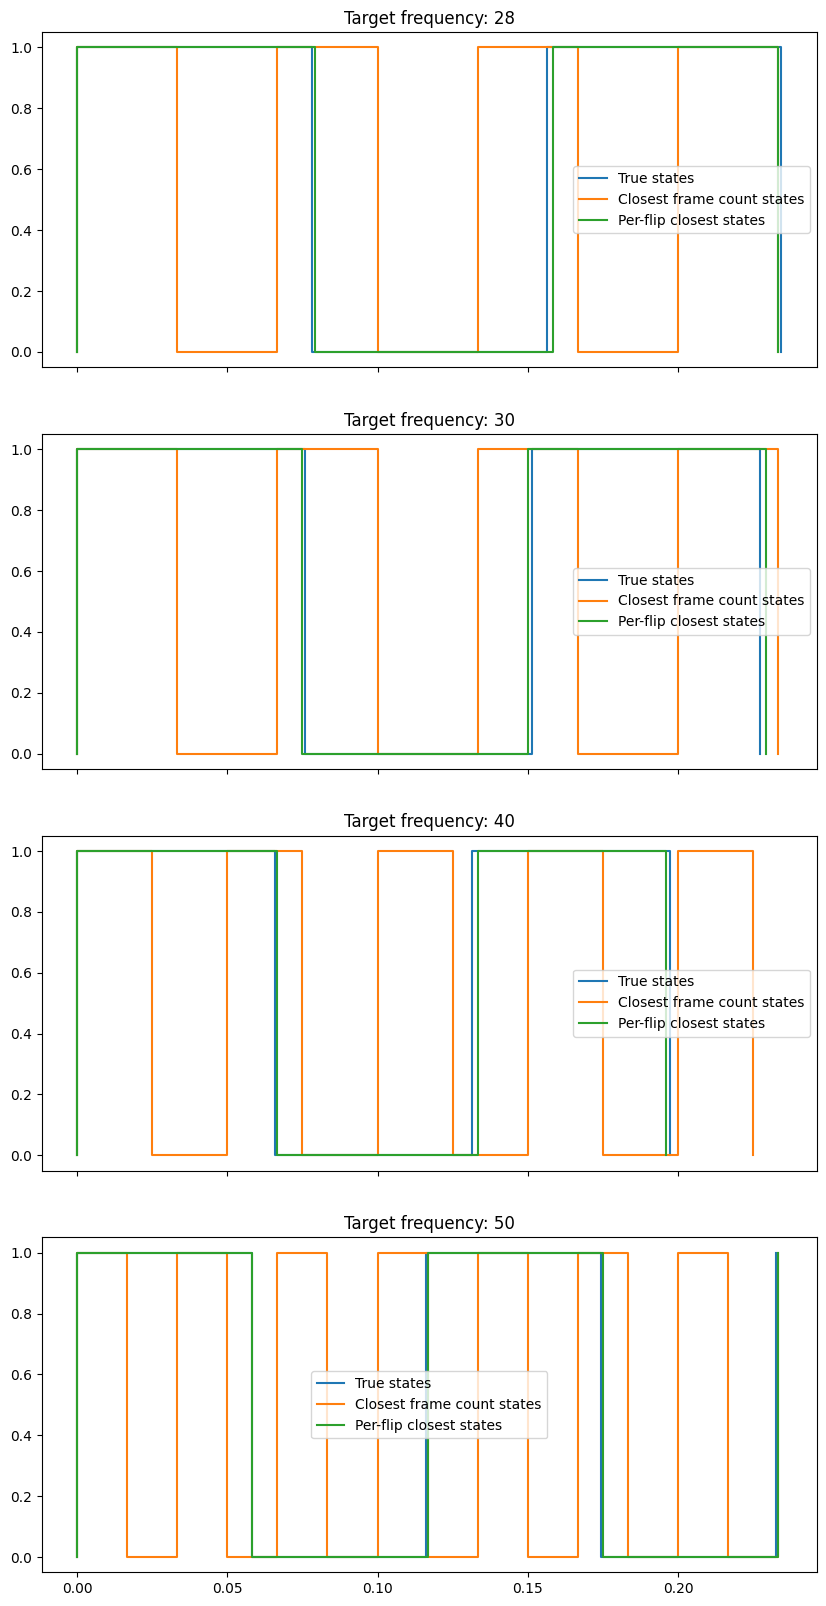

In [13]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(10, 20))
ax = ax.flatten()
plot_duration = 0.25
plot_t = np.linspace(0, plot_duration, 1000)
for i, (f, idx) in enumerate([(28, 24), (30, 26), (40, 36), (50, 46)]):
    ax[i].set_title("Target frequency: " + str(f))
    for name, t in {
        "True": alltargets[idx],
        "Closest frame count": np.arange(0, plot_duration, 1 / (get_nearest_f(f, framerate))),
        "Per-flip closest": allflips[idx],
    }.items():
        targetmask = t < plot_duration
        target_ts = np.hstack([np.array((0)), t[targetmask]])
        states = np.ones_like(target_ts, dtype=bool)
        states[::2] = False
        wheres = np.ones_like(target_ts, dtype=bool)
        wheres[::3] = False
        ax[i].step(target_ts, states, where="post", label=name + " states")
        ax[i].fill_between(target_ts, 0, 1, where=states, alpha=0.5)
    ax[i].legend()

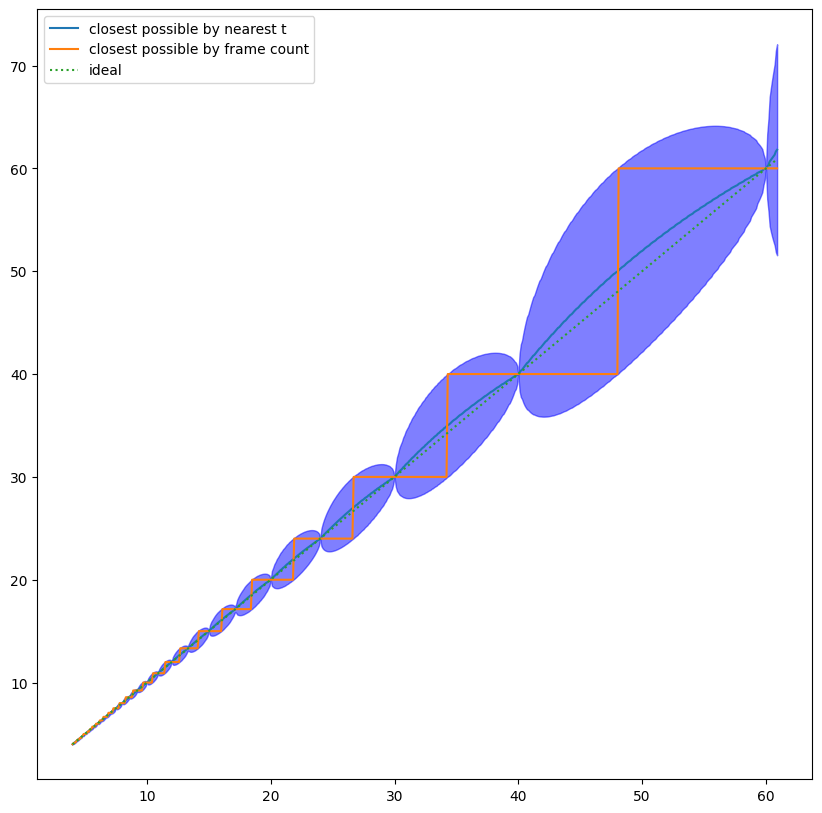

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(f_vals, actual_frs_nonoise, label="closest possible by nearest t")
plt.plot(f_vals, get_nearest_f(f_vals, framerate), label="closest possible by frame count")
plt.plot(f_vals, f_vals, ls=":", label="ideal")
means = np.array(actual_frs_nonoise)
stds = np.array(actual_frs_nonoise_std)
plt.fill_between(f_vals, means - stds, means + stds, alpha=0.5, color="blue")
plt.legend()
